# 可视化分析

本notebook加载模型与数据，进行模型评估、特征重要性、预测结果等可视化。

In [1]:
# 加载建模notebook保存的对象
import joblib
model_objs = joblib.load('../models/model_objects.pkl')
random_search = model_objs['random_search']
rfe_gbdt = model_objs['rfe_gbdt']
xgb_model = model_objs['xgb_model']
stacking_model = model_objs['stacking_model']
gbdt_mse = model_objs['gbdt_mse']
rfe_mse = model_objs['rfe_mse']
xgb_mse = model_objs['xgb_mse']
stack_mse = model_objs['stack_mse']

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score

# 加载模型和数据
model = joblib.load('../models/best_gbdt_model.pkl')
data = joblib.load('../data/processed_data.pkl')
X_train = data['X_train']
y_train = data['y_train']
feature_names = data['feature_names']

plt.rcParams['font.sans-serif'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 150
sns.set_style('whitegrid',{'font.sans-serif':['simhei','Arial']})

In [3]:
# 训练集预测与评估
y_train_pred = model.predict(X_train)
mse = mean_squared_error(y_train, y_train_pred)
r2 = r2_score(y_train, y_train_pred)
print(f"训练集MSE: {mse:.2f}")
print(f"训练集R2: {r2:.2f}")

训练集MSE: 0.00
训练集R2: 0.98


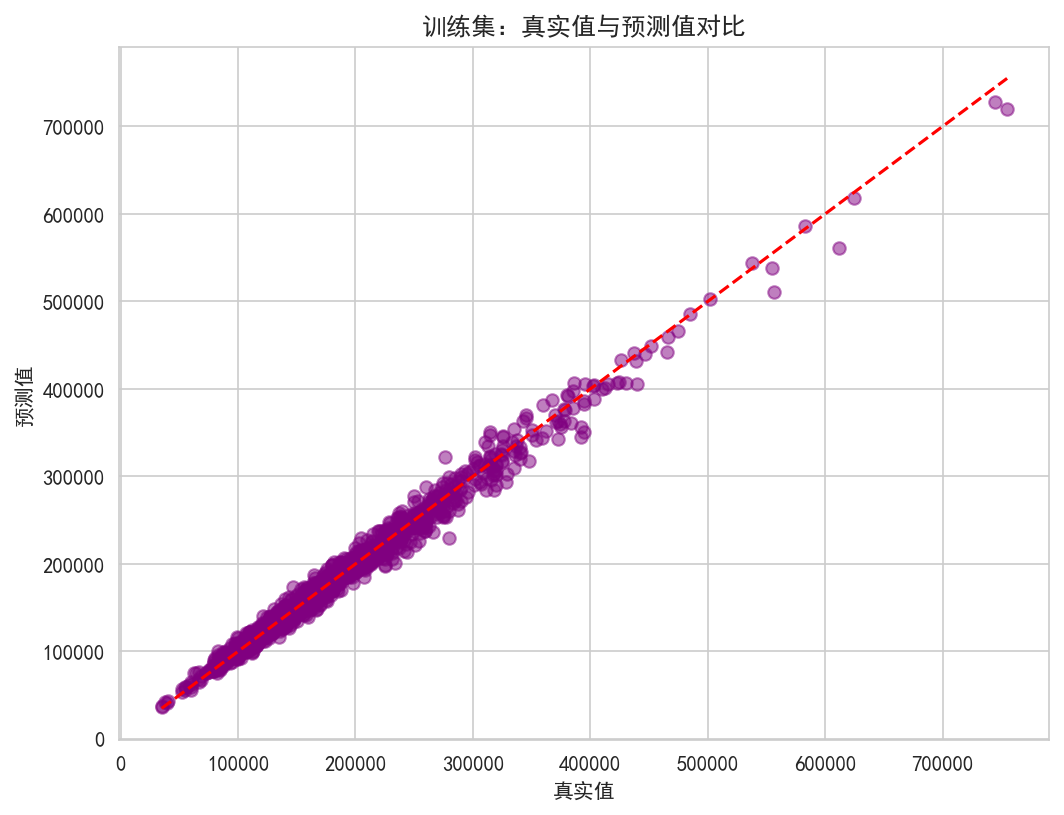

In [4]:
# 真实值与预测值对比散点图
plt.figure(figsize=(8,6))
plt.scatter(np.expm1(y_train), np.expm1(y_train_pred), alpha=0.5, color='purple')
plt.xlabel('真实值')
plt.ylabel('预测值')
plt.title('训练集：真实值与预测值对比')
plt.plot([min(np.expm1(y_train)), max(np.expm1(y_train))], [min(np.expm1(y_train)), max(np.expm1(y_train))], color='red', linestyle='--')
plt.savefig('../images/scatter_plot_actual_vs_predicted.png', bbox_inches='tight')
plt.show()

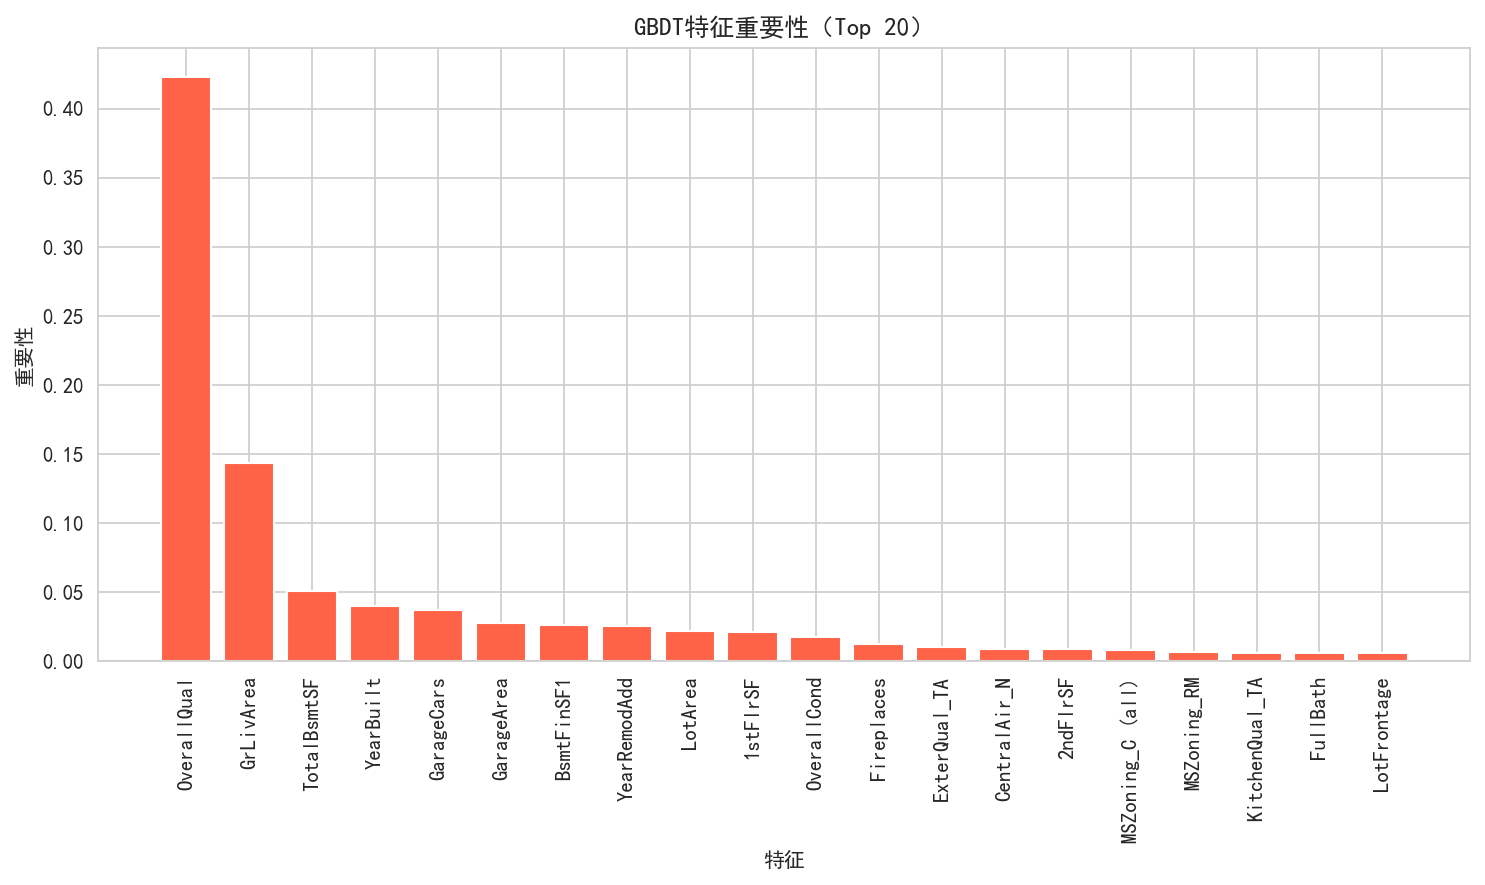

In [5]:
# 特征重要性条形图
importances = model.feature_importances_
indices = np.argsort(importances)[-20:][::-1]
plt.figure(figsize=(10,6))
plt.bar(range(len(indices)), importances[indices], color='tomato', align='center')
plt.xticks(range(len(indices)), np.array(feature_names)[indices], rotation=90)
plt.xlabel('特征')
plt.ylabel('重要性')
plt.title('GBDT特征重要性（Top 20）')
plt.tight_layout()
plt.savefig('../images/feature_importance_bar.png', bbox_inches='tight')
plt.show()

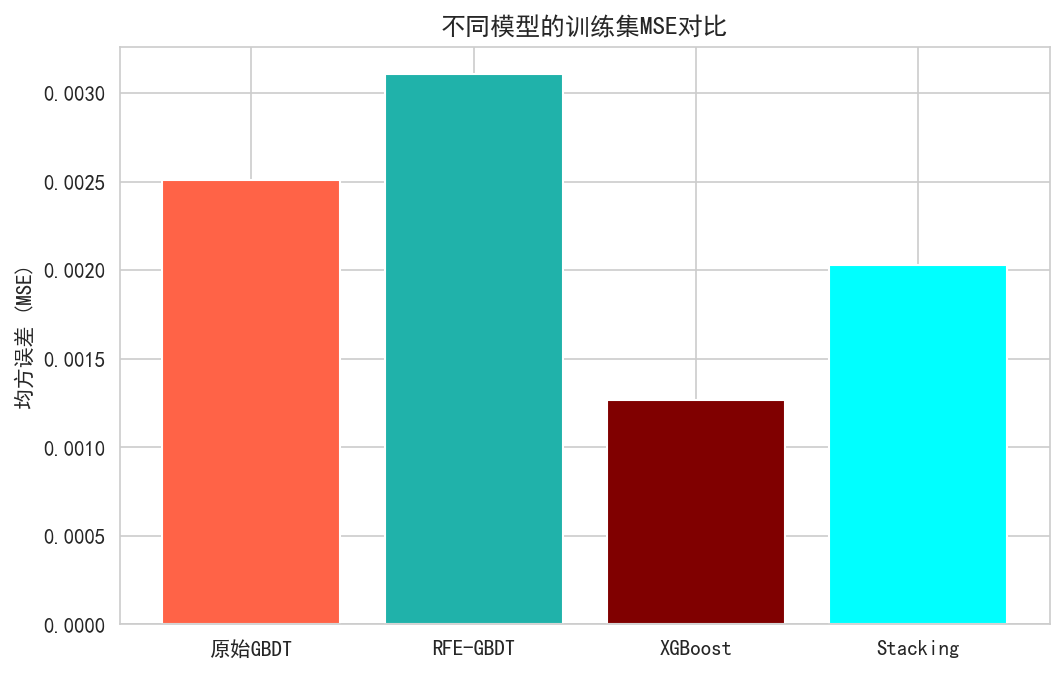

In [6]:
import pandas as pd
from math import pi


# 1. 不同模型训练集MSE对比
models = ['原始GBDT', 'RFE-GBDT', 'XGBoost', 'Stacking']
mse_list = [gbdt_mse, rfe_mse, xgb_mse, stack_mse]

# 检查并处理None值
mse_list_checked = [mse if mse is not None else np.nan for mse in mse_list]

if any([m is None for m in mse_list]):
    print("警告：有模型的MSE为None，可能未训练或未保存。图中将以空值显示。")

plt.figure(figsize=(8,5))
plt.bar(models, mse_list_checked, color=['tomato','lightseagreen','maroon','cyan'])
plt.ylabel('均方误差 (MSE)')
plt.title('不同模型的训练集MSE对比')
plt.savefig('../images/model_compare_mse.png', bbox_inches='tight')
plt.show()


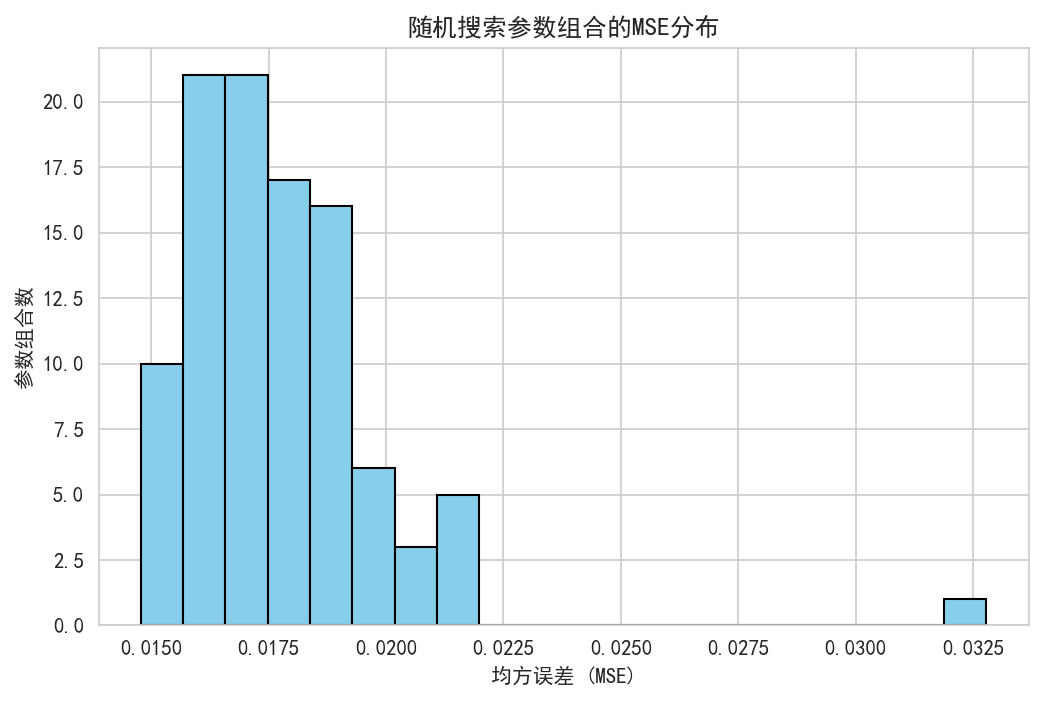

In [7]:

# 2. 随机搜索参数组合的MSE分布
results = pd.DataFrame(random_search.cv_results_)
scores = -results['mean_test_score']
plt.figure(figsize=(8,5))
plt.hist(scores, bins=20, color='skyblue', edgecolor='k')
plt.xlabel('均方误差 (MSE)')
plt.ylabel('参数组合数')
plt.title('随机搜索参数组合的MSE分布')
plt.grid(True)
plt.savefig('../images/random_search_mse_hist.png', bbox_inches='tight')
plt.show()


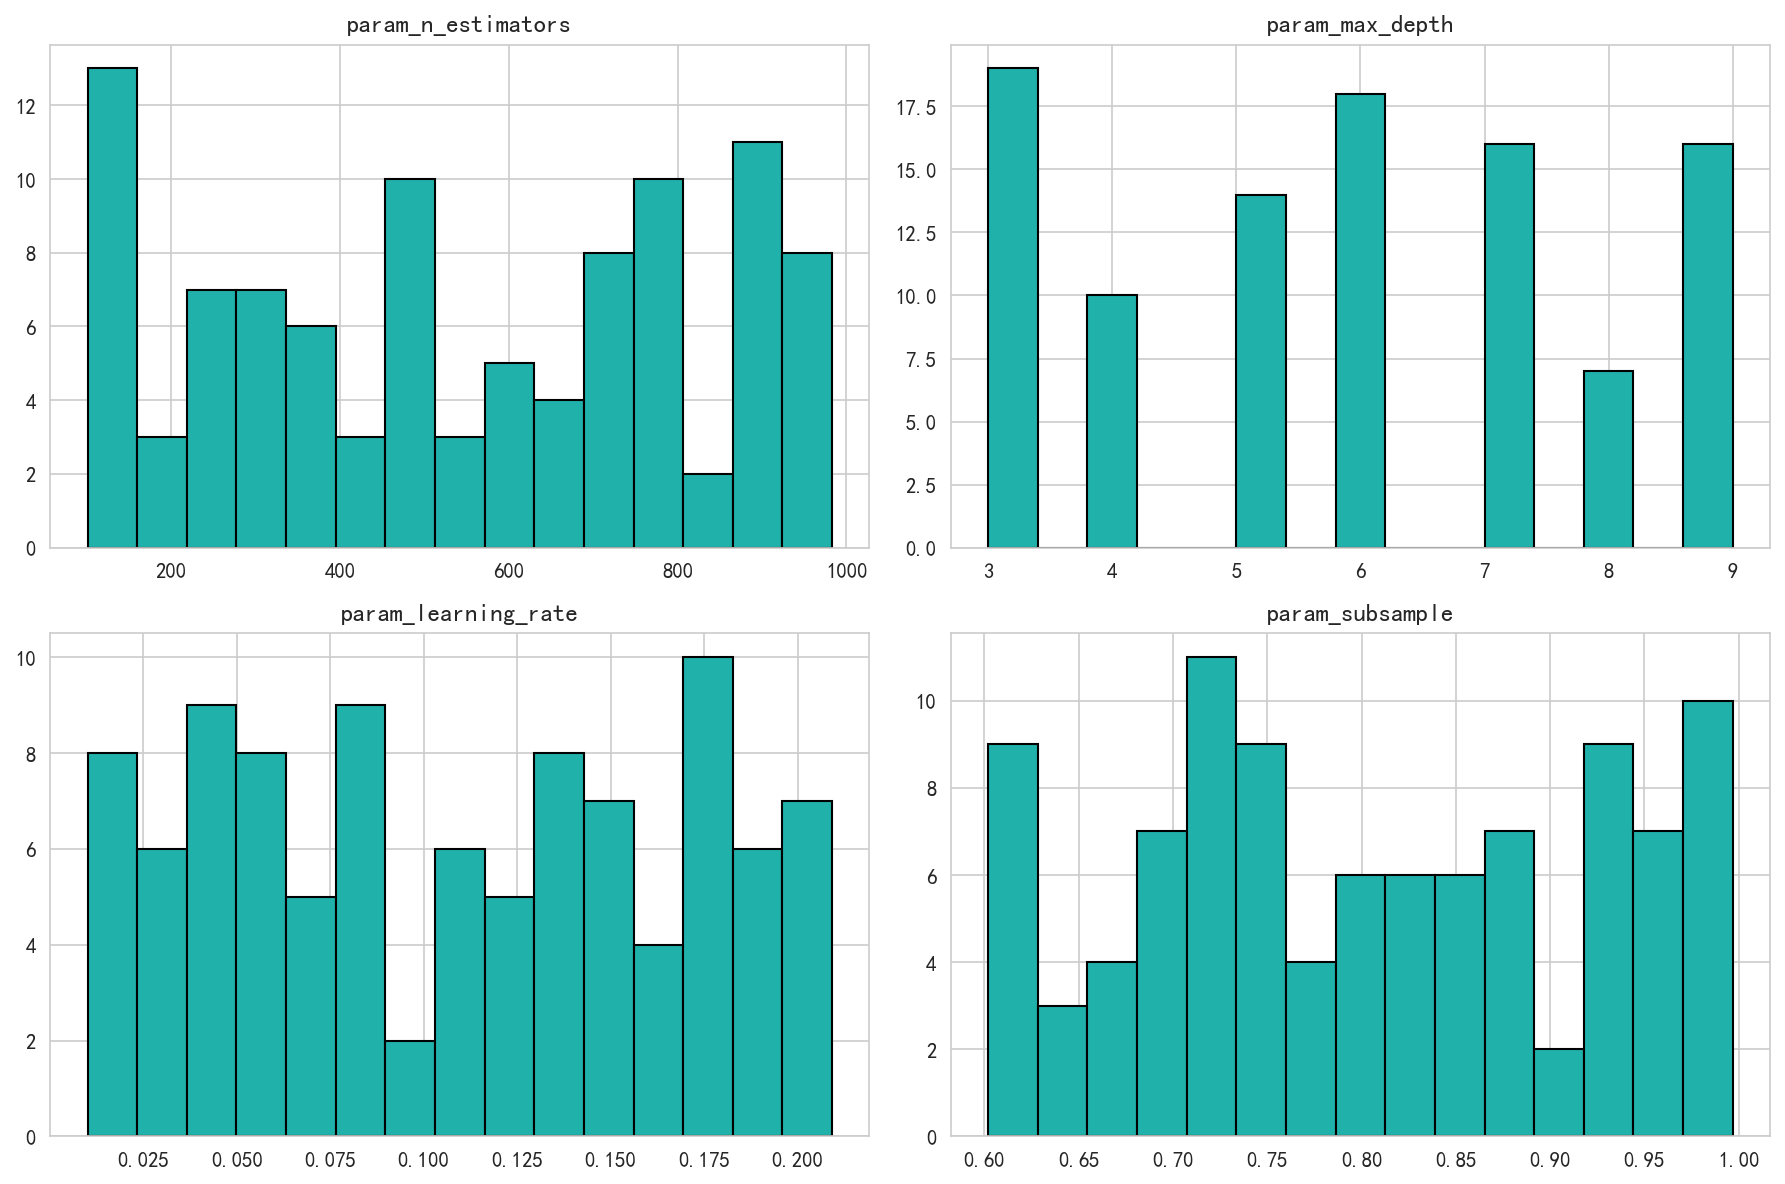

In [8]:

# 3. 超参数分布直方图
fig, axes = plt.subplots(2, 2, figsize=(12,8))
params = ['param_n_estimators', 'param_max_depth', 'param_learning_rate', 'param_subsample']
for ax, param in zip(axes.flatten(), params):
    ax.hist(results[param], bins=15, color='lightseagreen', edgecolor='k')
    ax.set_title(param)
plt.tight_layout()
plt.savefig('../images/hyperparam_distribution.png', bbox_inches='tight')
plt.show()


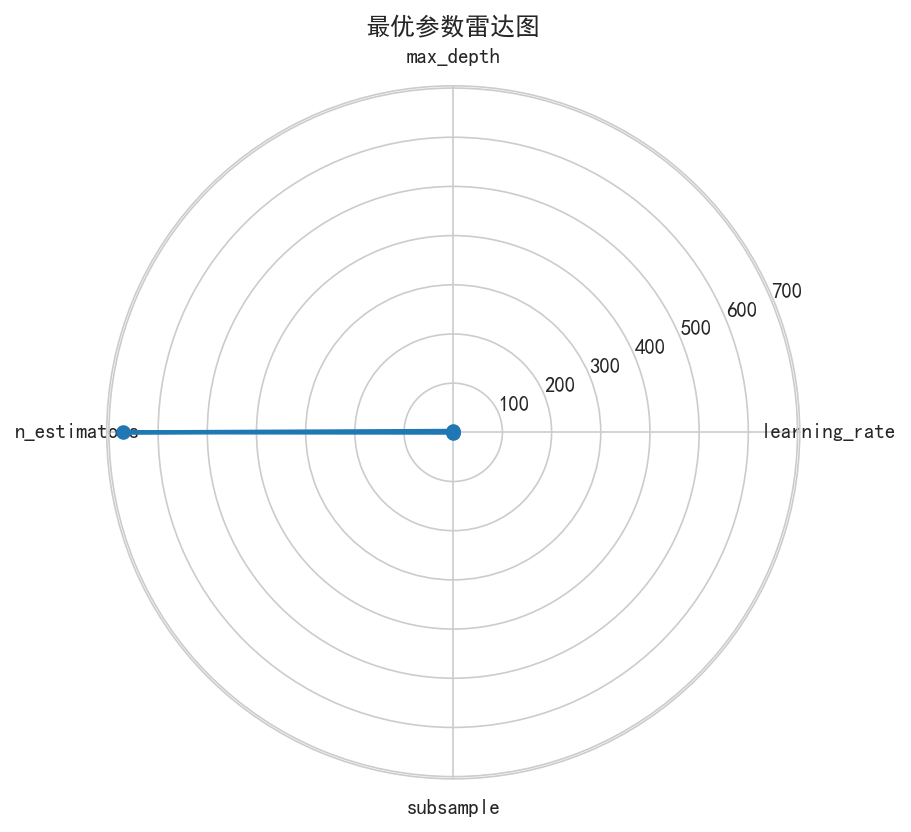

In [9]:

# 4. 最优参数雷达图
best_params = random_search.best_params_
labels = list(best_params.keys())
stats = [best_params[k] for k in labels]
angles = [n / float(len(labels)) * 2 * pi for n in range(len(labels))]
angles += angles[:1]
stats += stats[:1]
plt.figure(figsize=(6,6))
ax = plt.subplot(111, polar=True)
ax.plot(angles, stats, 'o-', linewidth=2)
ax.fill(angles, stats, alpha=0.25)
ax.set_thetagrids([a*180/pi for a in angles[:-1]], labels)
plt.title('最优参数雷达图')
plt.savefig('../images/best_params_radar.png', bbox_inches='tight')
plt.show()


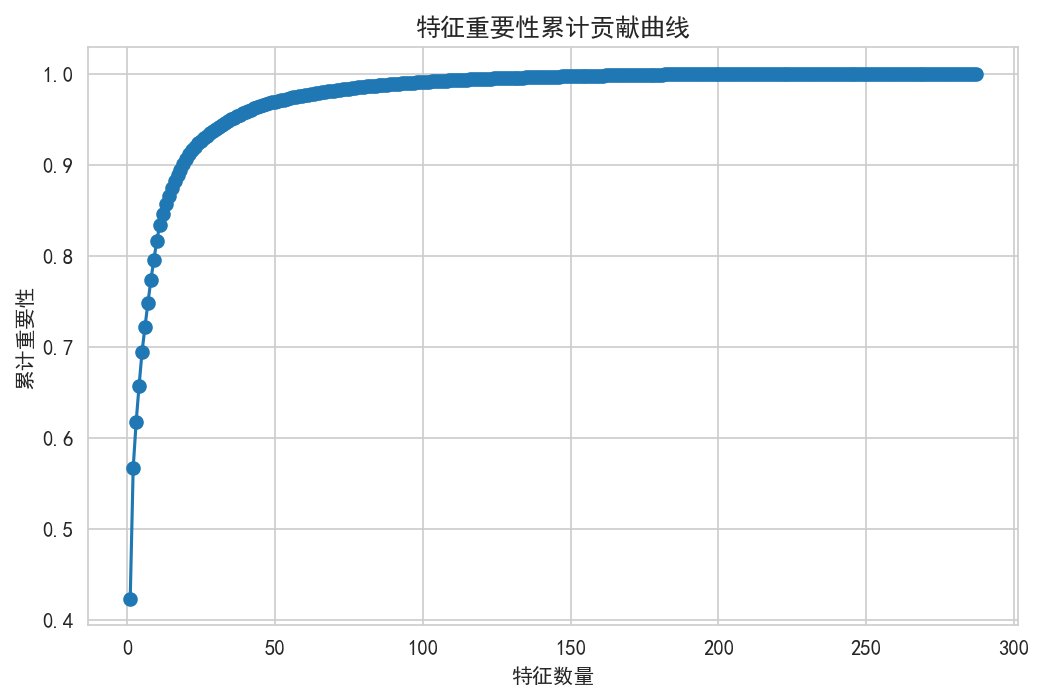

In [10]:

# 5. 特征重要性累计贡献曲线
importances = model.feature_importances_
sorted_importances = np.sort(importances)[::-1]
cum_importance = np.cumsum(sorted_importances)
plt.figure(figsize=(8,5))
plt.plot(range(1, len(cum_importance)+1), cum_importance, marker='o')
plt.xlabel('特征数量')
plt.ylabel('累计重要性')
plt.title('特征重要性累计贡献曲线')
plt.grid(True)
plt.savefig('../images/feature_importance_cumsum.png', bbox_inches='tight')
plt.show()


C:\Users\LXY_\AppData\Local\Temp\ipykernel_25724\777293983.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(cv_scores, labels=[f'Fold {i+1}' for i in range(5)])


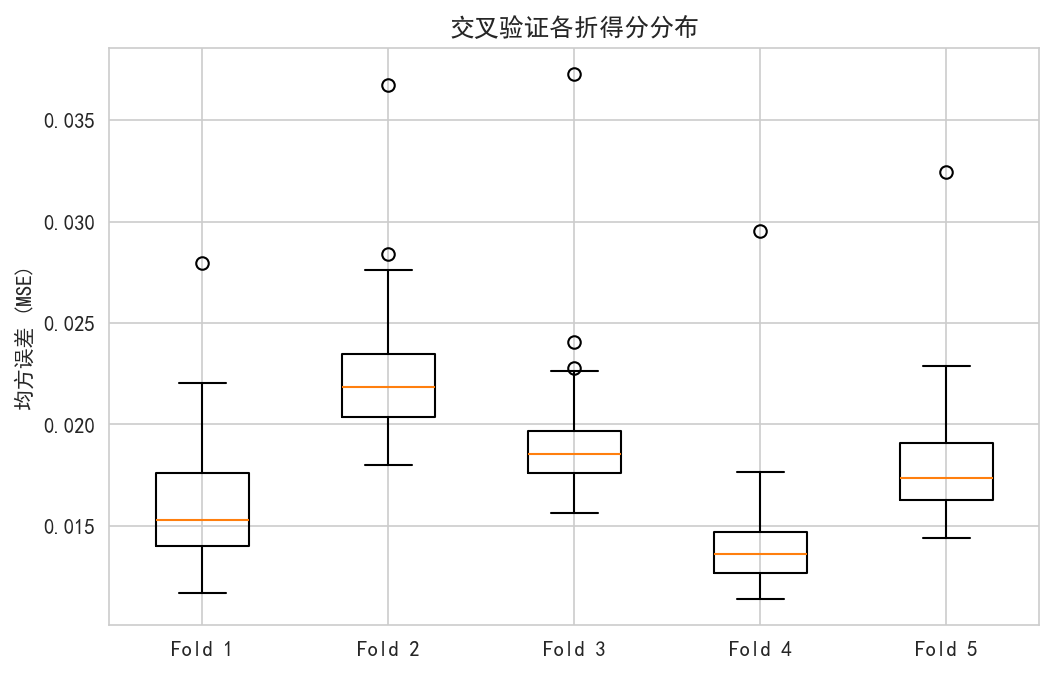

In [11]:

# 6. 交叉验证各折MSE箱线图
cv_scores = -results['split0_test_score'], -results['split1_test_score'], -results['split2_test_score'], -results['split3_test_score'], -results['split4_test_score']
plt.figure(figsize=(8,5))
plt.boxplot(cv_scores, labels=[f'Fold {i+1}' for i in range(5)])
plt.ylabel('均方误差 (MSE)')
plt.title('交叉验证各折得分分布')
plt.grid(True)
plt.savefig('../images/cv_score_boxplot.png', bbox_inches='tight')
plt.show()


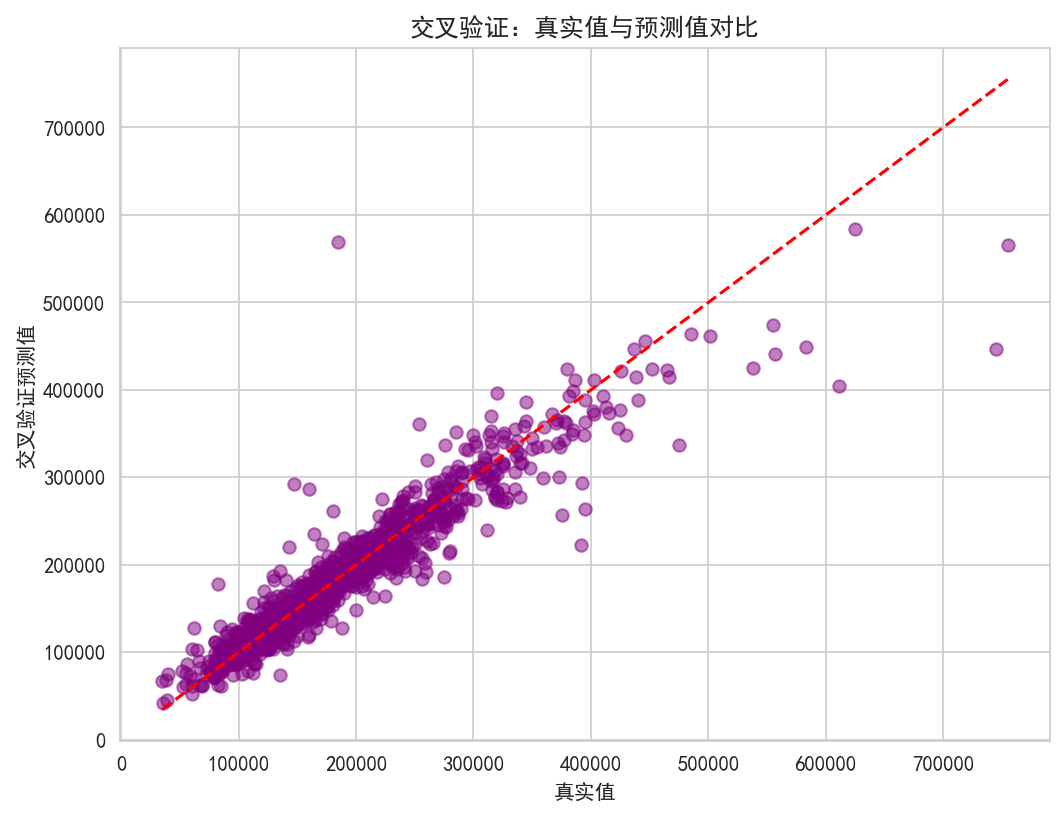

In [12]:

# 7. 交叉验证真实值与预测值对比
from sklearn.model_selection import cross_val_predict
val_pred = cross_val_predict(model, X_train, y_train, cv=5)
plt.figure(figsize=(8,6))
plt.scatter(np.expm1(y_train), np.expm1(val_pred), alpha=0.5, color='purple')
plt.xlabel('真实值')
plt.ylabel('交叉验证预测值')
plt.title('交叉验证：真实值与预测值对比')
plt.plot([min(np.expm1(y_train)), max(np.expm1(y_train))], [min(np.expm1(y_train)), max(np.expm1(y_train))], color='red', linestyle='--')
plt.savefig('../images/cv_actual_vs_pred.png', bbox_inches='tight')
plt.show()


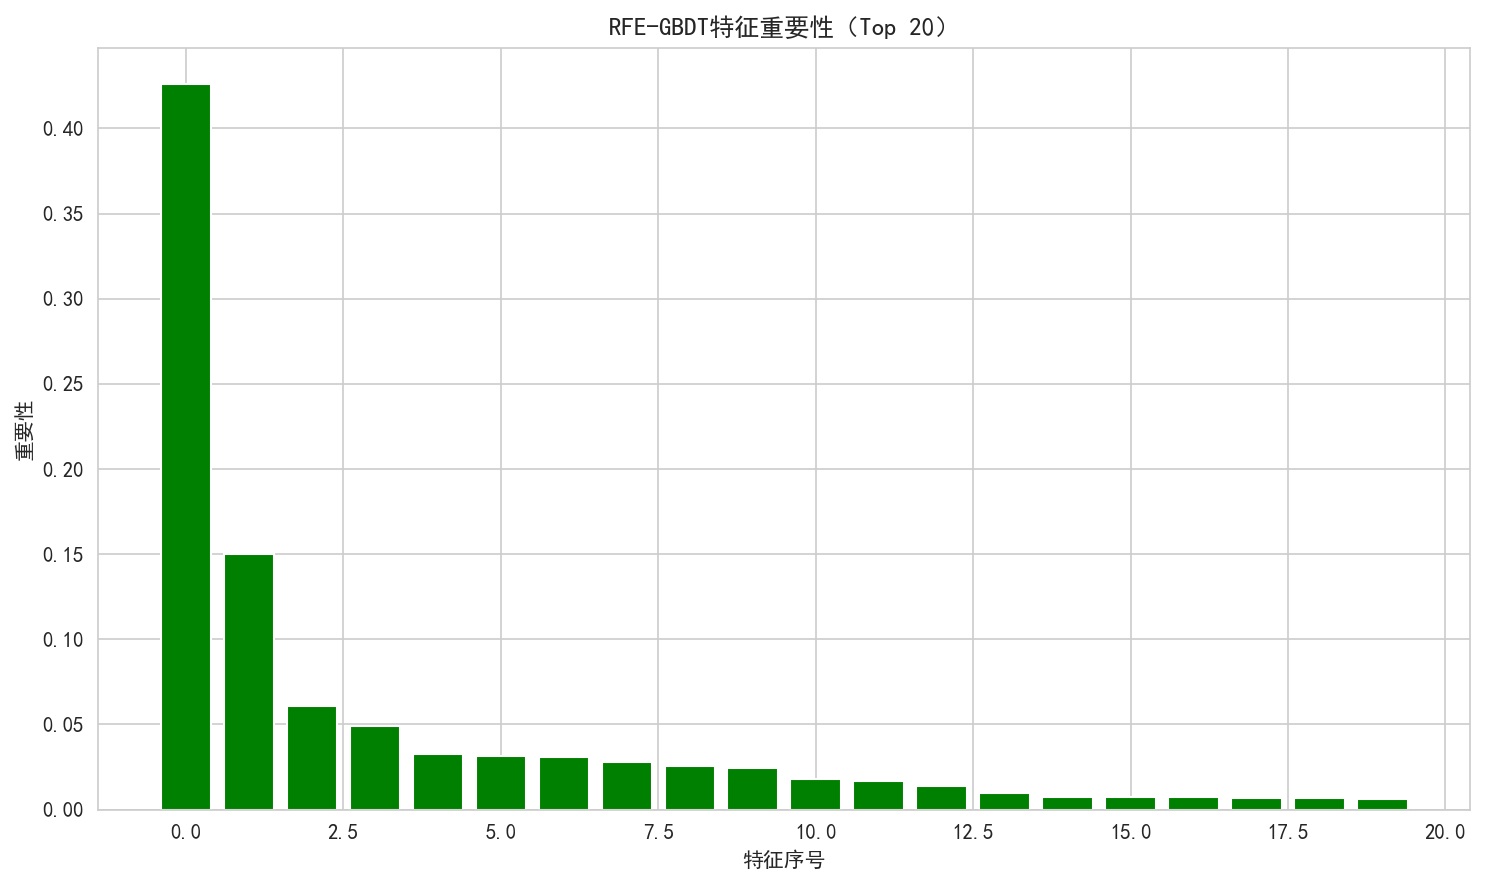

In [13]:

# 8. RFE-GBDT特征重要性条形图
importances_rfe = rfe_gbdt.feature_importances_
indices_rfe = np.argsort(importances_rfe)[-20:][::-1]
plt.figure(figsize=(10,6))
plt.bar(range(len(indices_rfe)), importances_rfe[indices_rfe], color='green', align='center')
plt.xlabel('特征序号')
plt.ylabel('重要性')
plt.title('RFE-GBDT特征重要性（Top 20）')
plt.tight_layout()
plt.savefig('../images/rfe_feature_importance_bar.png', bbox_inches='tight')
plt.show()


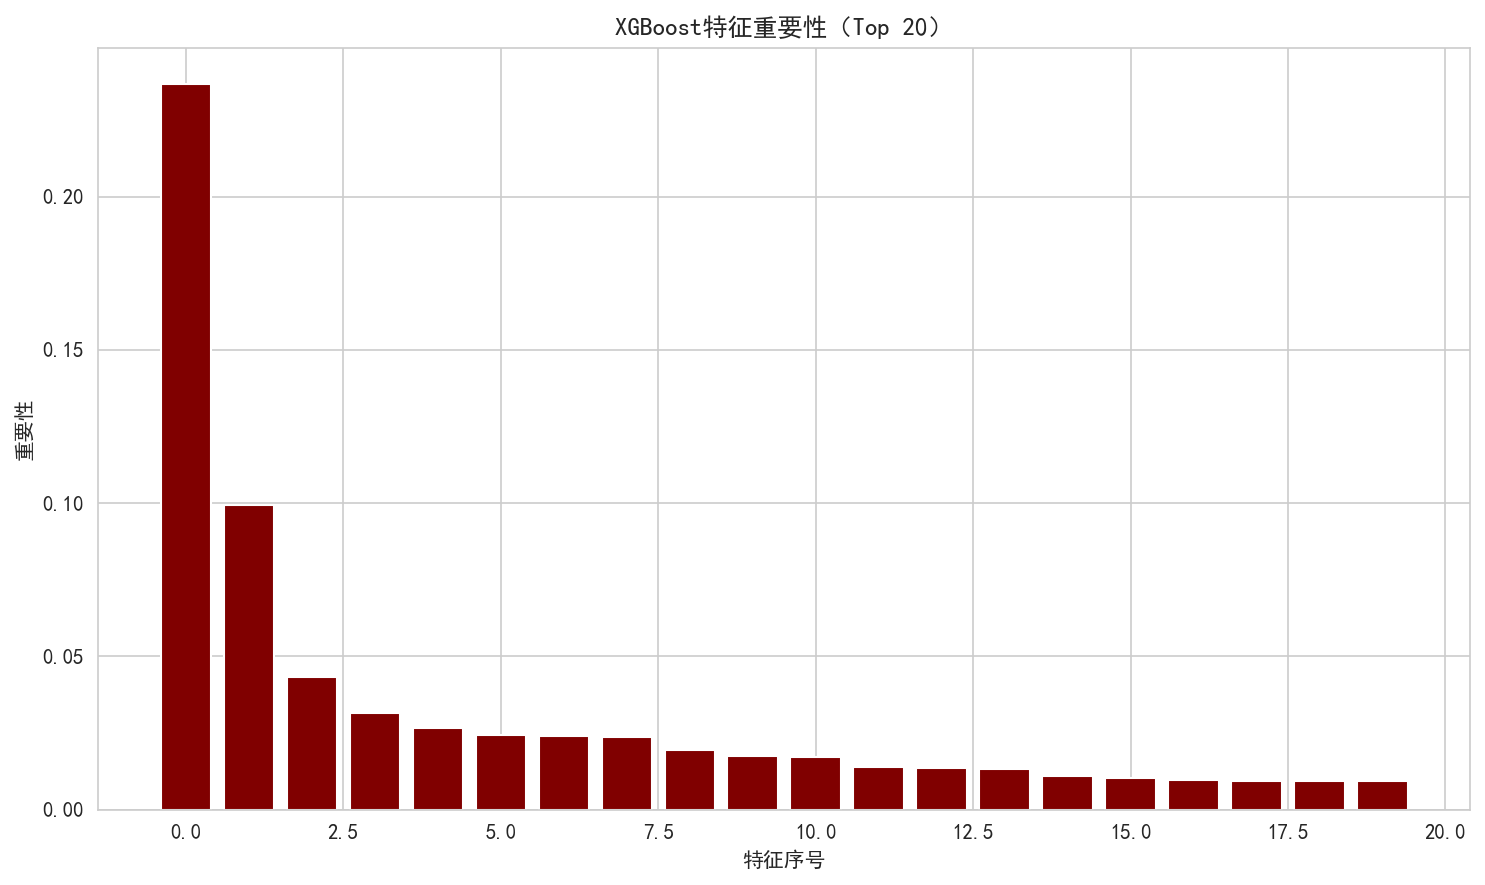

In [14]:

#  9. XGBoost特征重要性条形图
xgb_importances = xgb_model.feature_importances_
xgb_indices = np.argsort(xgb_importances)[-20:][::-1]
plt.figure(figsize=(10,6))
plt.bar(range(len(xgb_indices)), xgb_importances[xgb_indices], color='maroon', align='center')
plt.xlabel('特征序号')
plt.ylabel('重要性')
plt.title('XGBoost特征重要性（Top 20）')
plt.tight_layout()
plt.savefig('../images/xgb_feature_importance_bar.png', bbox_inches='tight')
plt.show()